Importing all necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import cv2
import glob
import string
from mlxtend.plotting import plot_decision_regions
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from sklearn.svm import SVC, NuSVC
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

Function to import images and labels of needed Training or Test fruits.

In [3]:
def getFruits(fruits, set):
    images = []
    labels = []
        
    for i,f in enumerate(fruits):
        fruitFolder_path = "../fruits-360/" + set + "/" + f
        j=0
        for image_path in glob.glob(fruitFolder_path + "/*.jpg"):
            image = cv2.imread(image_path)   
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            b , g , r = cv2.split(image)
            images.append(image)
            labels.append(i)
            j+=1
        print("There are " , j, set, "images of " , fruits[i].upper())
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

Getting fruits training and test sets

In [4]:
fruits = ['Pineapple' , 'Cocos', 'Avocado']
training_images, training_labels = getFruits(fruits,"Training")
test_images, test_labels = getFruits(fruits,"Test")
print(np.shape(training_images[0]))

There are  490 Training images of  PINEAPPLE
There are  490 Training images of  COCOS
There are  427 Training images of  AVOCADO
There are  166 Test images of  PINEAPPLE
There are  166 Test images of  COCOS
There are  143 Test images of  AVOCADO
(100, 100, 3)


# Data Exploration

### - Grid pictures of fruits

In [5]:
def plot_image_grid(images, nb_rows, nb_cols, figsize=(15, 15)):
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize)
    n = 0
    if(nb_rows == 1 or nb_cols ==1):
            for i in range(0,nb_cols+nb_rows-1):
                axs[i].axis('off')
                axs[i].imshow(images[n])
                n += 1
    else:
        for i in range(0, nb_rows):
            for j in range(0, nb_cols):
                axs[i, j].axis('off')
                axs[i, j].imshow(images[n])
                n += 1

Grid of first 100 pictures of pineapples training set

Images of class Pineapple


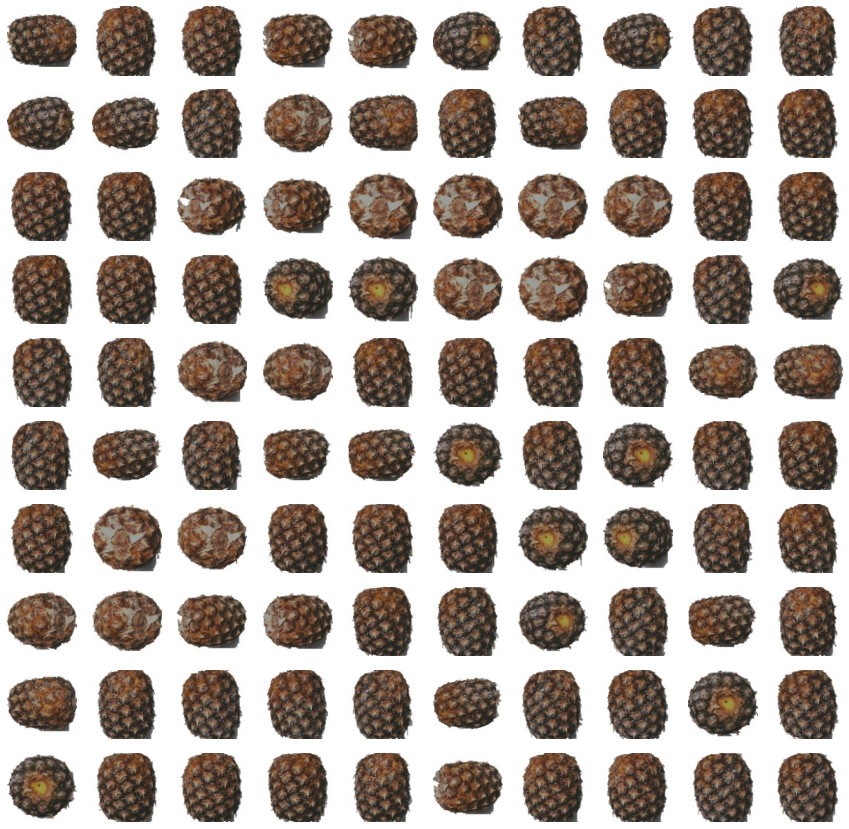

In [6]:
print("100 Images of ", fruits[training_labels[0]])
plot_image_grid(training_images[0:100],10,10)

100 Images of  Cocos


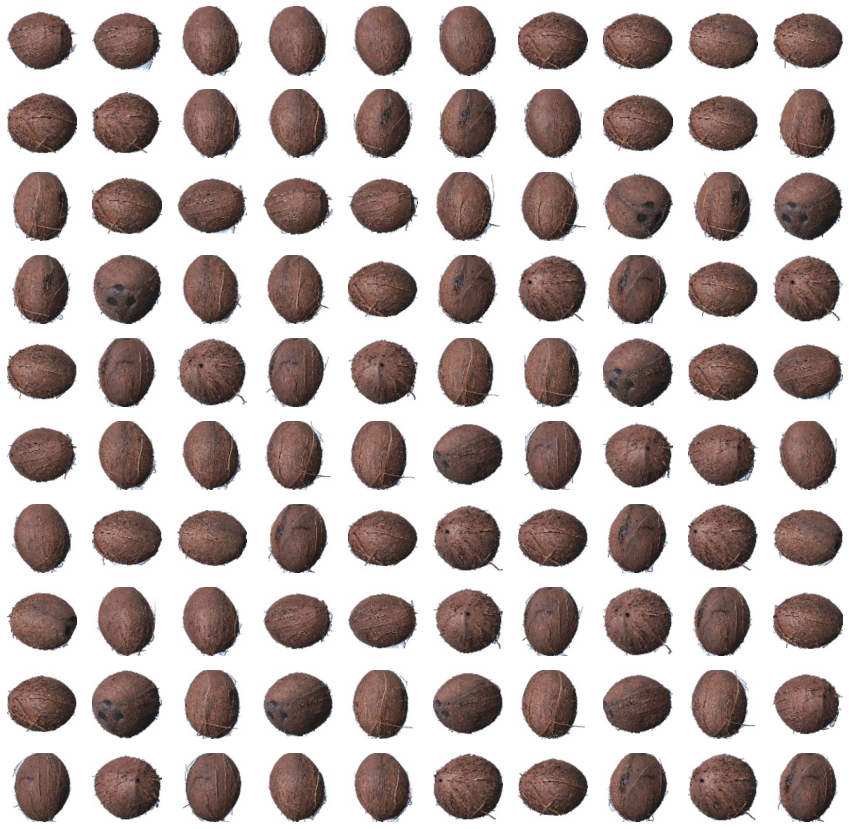

In [7]:
print("100 Images of ", fruits[training_labels[600]])
plot_image_grid(training_images[600:700],10,10)

### - Training vs Testing data ratio

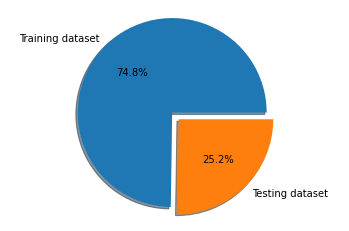

In [8]:
labels = ['Training dataset', 'Testing dataset']
sizes = [len(training_labels), len(test_labels)]
explode = (0.1, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=0)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

### Data transformation:
&emsp;&emsp;&emsp;&emsp; - Tranform RGB pics (100x100x3) to grayscale (100x100) <br>
&emsp;&emsp;&emsp;&emsp; - Linearizes each picture (100x100) into a linear array (10,000).

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform([i.flatten() for i in training_images])
X_test = scaler.fit_transform([i.flatten() for i in test_images])
print(np.shape(X_train[0]))
print(X_train[0])

(30000,)
[0.20987062 0.23186945 0.24191276 ... 0.07161149 0.05541321 0.04307305]


### - PCA on grayscale images and scale it back to RGB

In [9]:
def performPCA(n, images_scaled):
    pca = PCA(n)
    pc = pca.fit_transform(images_scaled) # 30,000 -> n
    return pca, pc

In [10]:
# function to reduce dimensions
def perform_and_inverse_PCA(n, images_scaled):
    pca, pc = performPCA(n, images_scaled) # 30,000 BW -> n
    reducedBWImages = pca.inverse_transform(pc) # n -> 30,000 BW
    reducedRGBImages = scaler.inverse_transform(reducedBWImages) # 30,000 BW -> 30,000 RGB
    return pc, reducedBWImages, reducedRGBImages

In [9]:
#Compute PCA on train data for 2, 10, 50 PCs
train_pc_2, train_reducedBWImages_2, train_reducedRGBImages_2 = perform_and_inverse_PCA(2, X_train)
train_pc_10, train_reducedBWImages_10, train_reducedRGBImages_10 = perform_and_inverse_PCA(10, X_train)
train_pc_50, train_reducedBWImages_50, train_reducedRGBImages_50 = perform_and_inverse_PCA(50, X_train)

#Compute PCA on test data for 2, 10, 50 PCs
test_pc_2, test_reducedBWImages_2, test_reducedRGBImages_2 = perform_and_inverse_PCA(2, X_test)
test_pc_10, test_reducedBWImages_10, test_reducedRGBImages_10 = perform_and_inverse_PCA(10, X_test)
test_pc_50, test_reducedBWImages_50, test_reducedRGBImages_50 = perform_and_inverse_PCA(50, X_test)


### - Show PCA results on a sample image for 2, 10, 50 principal components

In [10]:
def showPCA(image,X2, X10, X50):
    fig = plt.figure(figsize=(15,15))
    ax1 = fig.add_subplot(1,4,1)
    ax1.axis('off')
    ax1.set_title('Original image')
    plt.imshow(image)
    ax1 = fig.add_subplot(1,4,2)
    ax1.axis('off') 
    ax1.set_title('50 PC')
    plt.imshow(X50)
    ax1 = fig.add_subplot(1,4,3)
    ax1.axis('off') 
    ax1.set_title('10 PC')
    plt.imshow(X10)
    ax2 = fig.add_subplot(1,4,4)
    ax2.axis('off') 
    ax2.set_title('2 PC')
    plt.imshow(X2)
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


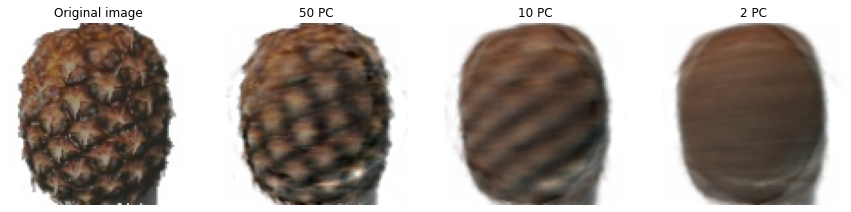

In [11]:
image_id = 1
image = training_images[image_id]

#Reshape in order to plot images
X2 = np.reshape(train_reducedRGBImages_2[image_id], (100,100,3)).astype(int)
X10 = np.reshape(train_reducedRGBImages_10[image_id], (100,100,3)).astype(int)
X50 = np.reshape(train_reducedRGBImages_50[image_id], (100,100,3)).astype(int)

showPCA(image, X2, X10, X50)

# SVM

### - SVM + PCA

Train and Test SVM model considering different count of PCs to find best accuracy.

Best acuracy obtained for linear SVM classifier with PCA is 50.0% with PCA of 1 features.


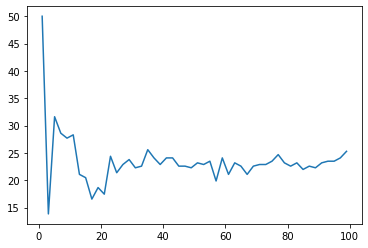

In [16]:
x_graph = list(range(1,100,2))
y_graph = []
max_accuracy = max_accuracy_pc = 0
for i in x_graph:
    # PCA
    pca, train_pc = performPCA(i, X_train)
    pca, test_pc = performPCA(i, X_test)
    
    # SVM train
    svm = SVC(kernel="linear", probability=True) # Probability = True, enables 5-fold cross validation.
    svm.fit(train_pc, training_labels)
    
    # SVM test
    y_pred=svm.predict(test_pc)
    precision = metrics.accuracy_score(y_pred, test_labels) * 100
    y_graph.append(precision)
    if precision > max_accuracy:
        max_accuracy = precision
        max_accuracy_pc = i

print(f"Best acuracy obtained for linear SVM classifier with PCA is {max_accuracy}% with PCA of {max_accuracy_pc} features.")

plt.plot(x_graph,y_graph)
plt.show()

Visualize linear SVM decision boundaries after dimensionality reduction to 2 features.

Accuracy with SVM considering only first 2PC: 13.86%


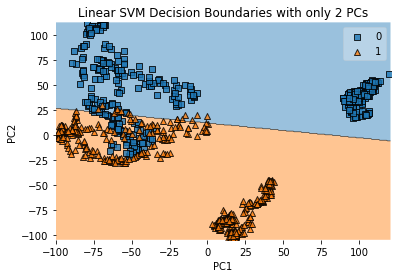

In [5]:
# PCA reduce dimensions to 2
pca = PCA(n_components=2)
X_train2D = pca.fit_transform(X_train)
X_test2D = pca.fit_transform(X_test)

# SVM train
svm = SVC(kernel='linear', probability=True) # Probability = True, enables 5-fold cross validation.
svm.fit(X_train2D, training_labels) 

# SVM test
test_predictions = svm.predict(X_test2D)
precision = metrics.accuracy_score(test_predictions, test_labels) * 100
print("Accuracy with SVM considering only first 2PC: {0:.2f}%".format(precision))

# plot decision boundry
plot_decision_regions(X_train2D, training_labels, clf=svm, legend=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Linear SVM Decision Boundaries with only 2 PCs')
plt.show()

### - SVM without PCA

In [6]:
# SVM train
svm = SVC(kernel="linear", probability=True) # Probability = True, enables 5-fold cross validation.
svm.fit(X_train, training_labels)

# SVM test
y_pred=svm.predict(X_test)
precision = metrics.accuracy_score(y_pred, test_labels) * 100

print(f"Accuracy obtained for linear SVM classifier without PCA is {precision}%.")

Acuracy obtained for linear SVM classifier without PCA is 97.59036144578313%.


# SVM with RBF kernel

### - RBF + PCA

Best acuracy obtained for RBF SVM classifier with PCA is 76.80722891566265% with PCA of 1 features.


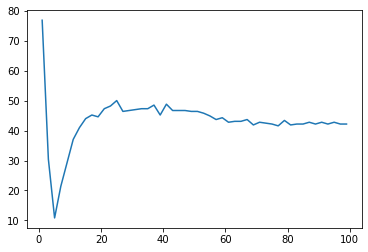

In [15]:
x_graph = list(range(1,100,2))
y_graph = []
max_accuracy = max_accuracy_pc = 0
for i in x_graph:
    # PCA
    pca, train_pc = performPCA(i, X_train)
    pca, test_pc = performPCA(i, X_test)
    
    # SVM train
    svm = SVC(kernel="rbf", probability=True) # Probability = True, enables 5-fold cross validation.
    svm.fit(train_pc, training_labels)
    
    # SVM test
    y_pred=svm.predict(test_pc)
    precision = metrics.accuracy_score(y_pred, test_labels) * 100
    y_graph.append(precision)
    if precision > max_accuracy:
        max_accuracy = precision
        max_accuracy_pc = i

print(f"Best acuracy obtained for RBF SVM classifier with PCA is {max_accuracy}% with PCA of {max_accuracy_pc} features.")

plt.plot(x_graph,y_graph)
plt.show()

Accuracy with RBF considering only first 2PC: 57.23%


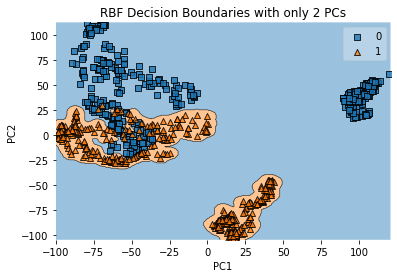

In [7]:
# PCA reduce dimensions to 2
pca = PCA(n_components=2)
X_train2D = pca.fit_transform(X_train)
X_test2D = pca.fit_transform(X_test)

# SVM train
svm = SVC(gamma = 0.08, kernel='rbf', probability=True) # Probability = True, enables 5-fold cross validation.
svm.fit(X_train2D, training_labels) 

# SVM test
test_predictions = svm.predict(X_test2D)
precision = metrics.accuracy_score(test_predictions, test_labels) * 100
print("Accuracy with RBF considering only first 2PC: {0:.2f}%".format(precision))

# plot decision boundry
plot_decision_regions(X_train2D, training_labels, clf=svm, legend=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('RBF Decision Boundaries with only 2 PCs')
plt.show()

### - RBF without PCA

In [ ]:
# SVM train
svm = SVC(kernel="rbf", probability=True)
svm.fit(X_train, training_labels)

# SVM test
y_pred=svm.predict(X_test)
precision = metrics.accuracy_score(y_pred, test_labels) * 100
print(f"Accuracy with RBF: {precision}%")

Accuracy with RBF: 97.28915662650603%


# KNN

### - KNN + PCA

In [30]:
max_accuracy = max_accuracy_k = 0

pca, train_pc = performPCA(1, X_train)
pca, test_pc = performPCA(1, X_test)
for k in range(1, 51):                
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_pc, training_labels)
    
    y_pred = knn.predict(test_pc)
    precision = metrics.accuracy_score(y_pred, test_labels) * 100

    if(precision>max_accuracy):
        max_accuracy = precision
        max_accuracy_k = k
print(f"Max accuracy: {max_accuracy}% with 1 principal components, and {max_accuracy_k} nearest neighbours.")


Max accuracy: 76.20481927710844% with 1 principal components, and 49 nearest neighbours.


### - KNN without PCA

Max accuracy: 96.98795180722891% with 2 nearest neighbours.


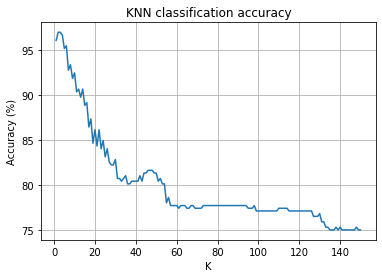

In [23]:
x_graph = list(range(1,151))
y_graph = []
max_accuracy = max_accuracy_k = 0

for k in x_graph:     
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, training_labels)
    
    y_pred = knn.predict(X_test)
    precision = metrics.accuracy_score(y_pred, test_labels) * 100
    y_graph.append(precision)
    
    if precision > max_accuracy:
        max_accuracy = precision
        max_accuracy_k = k

print(f"Max accuracy: {max_accuracy}% with {max_accuracy_k} nearest neighbours.")
plt.plot(x_graph, y_graph)
plt.xlabel("K")
plt.ylabel("Accuracy (%)")
plt.grid()
plt.title("KNN classification accuracy")
plt.show()

# DECISION TREES

### - DT + PCA

In [ ]:
# PCA
pca, train_pc = performPCA(322, X_train)
pca, test_pc = performPCA(322, X_test)

# SVM train
dt = DecisionTreeClassifier(criterion='entropy')
dt.fit(train_pc, training_labels)

# SVM test
y_pred=dt.predict(test_pc)
precision = metrics.accuracy_score(y_pred, test_labels) * 100

print("accuracy:", precision)

accuracy: 23.49397590361446


In [ ]:
max_accuracy = max_accuracy_pc = max_accuracy_d = 0
for p in range(1,11,5):
    for d in range(1,25):
        # PCA
        pca, train_pc = performPCA(p, X_train)
        pca, test_pc = performPCA(p, X_test)
        
        # SVM train
        dt = DecisionTreeClassifier(criterion='entropy', max_depth=d)
        dt.fit(train_pc, training_labels)
        
        # SVM test
        y_pred=dt.predict(test_pc)
        precision = metrics.accuracy_score(y_pred, test_labels) * 100
        if precision > max_accuracy:
            max_accuracy = precision
            max_accuracy_d = d
            max_accuracy_pc = p
            
print("max_accuracy:", max_accuracy, "at", max_accuracy_pc, "principal components and tree of", max_accuracy_d, "depth.")

max_accuracy: 75.0 at 1 principal components and tree of 1 depth.
